# Pregunta de programación. Previas a la hackatón URP

El problema descrito se puede plantear como una modificación de un problema clásico llamado **problema del agente viajero** (*TSP*). Si interpretamos a las ciudades como nodos de un grafo y las conexiones entre estos como los caminos posibles a tomar (con un costo respectivo), entonces el *TSP* busca generar una ruta de mínimo costo (en este caso, distancia) que conecte a todos los nodos del grafo, tal que cada nodo sea visitado una única vez y cuente con una única salida. La versión modificada del *TSP* que resuelve **el problema brindado** consiste en que se debe cortar el arco dirigido dentro de la solución del *TSP* que tenga el mayor costo (pues se parte de una ciudad y se finaliza en otra distinta).

Nuestro equipo reliza esto mediante **programación lineal** con la librería **docplex** de Python.

Primero se debe instalar **IBM ILOG Optimization Studio** desde [acá](https://www.ibm.com/pe-es/products/ilog-cplex-optimization-studio). Luego de ello, leer la documentación de **docplex** que incluye instrucciones de instalación [acá](https://github.com/IBMDecisionOptimization/docplex-examples)

In [18]:
!pip install docplex --force

  Using cached https://files.pythonhosted.org/packages/7d/e3/20f3d364d6c8e5d2353c72a67778eb189176f08e873c9900e10c0287b84b/requests-2.21.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/73/fb/00a976f728d0d1fecfe898238ce23f502a721c0ac0ecfedb80e0d88c64e9/six-1.12.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/60/75/f692a584e85b7eaba0e03827b3d51f45f571c2e793dd731e598828d380aa/certifi-2019.3.9-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/bc/a9/01ffebfb562e4274b6487b4bb1ddec7ca55ec7510b22e4c51f14098443b8/chardet-3.0.4-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/df/1c/59cca3abf96f991f2ec3131a4ffe72ae3d9ea1f5894abe8a9c5e3c77cfee/urllib3-1.24.2-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/14/2c/cd551d81dbe15200be1cf41cd03869a46fe7226e7450af7a6545bfc474c9/idna-2.8-py2.py3-none-any.whl
spyder 3.3.2 requires pyqt5<5.10; python_version >= "3", whi

In [19]:
# Todas las liberías necesarias:
from docplex.mp.model import Model # importando la clase 'Model' de Programación Lineal
import numpy as np # álgebra lineal
import pandas as pd # DataFrames para manipular tablas de datos
import networkx as nx

ModuleNotFoundError: No module named 'docplex'

In [16]:
# Carga de archivo txt:
lista_data = []
with open('rutas.txt') as file:
    todas_lineas = file.readlines()
    for linea in todas_lineas:
        lista_temp = []
        loc_to = linea.find(" to ")
        loc_igual = linea.find(" = ")
        lista_temp.append(linea[0:loc_to]) # origen
        lista_temp.append(linea[loc_to+4:loc_igual]) # destino
        lista_temp.append(float(linea[loc_igual+3:][:-1])) # distancia eliminando el '\n'
        lista_data.append(lista_temp)
        
print(lista_data)

[['AlphaCentauri', 'Snowdin', 66.0], ['AlphaCentauri', 'Tambi', 28.0], ['AlphaCentauri', 'Faerun', 60.0], ['AlphaCentauri', 'Norrath', 34.0], ['AlphaCentauri', 'Straylight', 34.0], ['AlphaCentauri', 'Tristram', 3.0], ['AlphaCentauri', 'Arbre', 108.0], ['Snowdin', 'Tambi', 22.0], ['Snowdin', 'Faerun', 12.0], ['Snowdin', 'Norrath', 91.0], ['Snowdin', 'Straylight', 121.0], ['Snowdin', 'Tristram', 111.0], ['Snowdin', 'Arbre', 71.0], ['Tambi', 'Faerun', 39.0], ['Tambi', 'Norrath', 113.0], ['Tambi', 'Straylight', 130.0], ['Tambi', 'Tristram', 35.0], ['Tambi', 'Arbre', 40.0], ['Faerun', 'Norrath', 63.0], ['Faerun', 'Straylight', 21.0], ['Faerun', 'Tristram', 57.0], ['Faerun', 'Arbre', 83.0], ['Norrath', 'Straylight', 9.0], ['Norrath', 'Tristram', 50.0], ['Norrath', 'Arbre', 60.0], ['Straylight', 'Tristram', 27.0], ['Straylight', 'Arbre', 81.0], ['Tristram', 'Arbre', 9.0]]


In [3]:
# Dataframe con la información:
dataframe_arcos = pd.DataFrame(lista_data)
dataframe_arcos.head()

NameError: name 'pd' is not defined

In [4]:
# Extraemos las etiquetas de ciudades:
ciudades_unicas = list(set(np.hstack((dataframe_arcos[0], dataframe_arcos[1]))))
ciudades_unicas.sort()
ciudades_unicas

NameError: name 'np' is not defined

In [5]:
# Creamos matriz de distancias:
matriz_dist = pd.DataFrame(data = np.full(shape=(len(ciudades_unicas), len(ciudades_unicas)), fill_value = 999999),
                           index = ciudades_unicas,
                           columns = ciudades_unicas)

# Rellenamos la matriz con las distancias correctas:
for row in dataframe_arcos.iterrows():
    orig = row[1][0]
    dest = row[1][1]
    dist = row[1][2]
    matriz_dist.loc[orig, dest] = dist

matriz_dist # vemos matriz finalizada!

NameError: name 'pd' is not defined

Abajo modelamos las restricciones de la formulación TSP de Tucker-Miller-Zemlin (1960), desde su paper *"Integer Programming Formulation of Traveling Salesman Problems"*

In [6]:
def ModeloTSP(dataframe_distancias, etiquetas_nodos, str_nombre_modelo):
    """
    Devuelve un objeto 'Model' de CPLEX que resuelve el TSP con la formulación propuesta por Tucker-Miller-Zemlin.
    """
    # Creamos nuestra instancia del modelo:
    m = Model(name = str_nombre_modelo)
    
    cantidad_nodos = len(etiquetas_nodos)
    
    ## Parámetros del modelo:
    # SET's:
    indices_nodos = etiquetas_nodos.copy()

    # VAR's:
    # Lo de abajo se llama comprensión de diccionario! Nótese que eliminamos todos los i==j, ahorrando variables y tiempo
    x = {(i,j): m.binary_var(name='x_{0}_{1}'.format(i,j)) for i in indices_nodos for j in indices_nodos if i!=j}
    u = {i: m.integer_var(name='u_{0}'.format(i)) for i in indices_nodos}

    # Función Objetivo:
    m.minimize(
        m.sum(
            x[i,j] * dataframe_distancias.loc[i,j] for i in indices_nodos for j in indices_nodos if i!=j
        )
    )
    
    ## RESTRICCIONES:
    # Entrada:
    for j in indices_nodos:
        m.add_constraint(m.sum(x[i,j] for i in indices_nodos if i!=j) == 1, 
                         ctname='entrada_{0}'.format(j))

    # Salida:
    for i in indices_nodos:
        m.add_constraint(m.sum(x[i,j] for j in indices_nodos if i!=j) == 1, 
                         ctname='salida_{0}'.format(i))

    # Subtours:
    for i in indices_nodos[1:]: # tomamos a partir del segundo indice (empieza en '0')
        for j in indices_nodos[1:]: # tomamos a partir del segundo indice (empieza en '0')
            if i!=j:
                m.add_constraint(u[i] - u[j] + cantidad_nodos * x[i,j] <= cantidad_nodos - 1, 
                                 ctname='subtour_{0}_{1}'.format(i, j))
    
    print(m.print_information())
    
    return m


def ObtenerMatrizViajes(dataframe_distancias, etiquetas_nodos, modelo_resuelto):
    """
    Obtenemos la matriz de viajes, el cual es el resultado del modelo TSP Tucker-Miller-Zemlin.
    """
    # Obtenemos las conexiones a modo de lista:
    conexiones = list(
        map(
            lambda x: tuple(x.split('_')),
            [
                i[2:] for i in list(modelo_resuelto.solution.as_dict().keys()) if i[0] == 'x' # magia!
            ]
        )
    )
    
    # Construimos la matriz binaria de conexiones:
    matriz_conexiones = pd.DataFrame(data=np.zeros_like(dataframe_distancias.copy().values), 
                                     index=etiquetas_nodos, 
                                     columns=etiquetas_nodos)
    for i,j in conexiones:
        matriz_conexiones.loc[i,j] = 1

    return matriz_conexiones

In [7]:
# Creando el modelo:
modelo_tsp_hacka = ModeloTSP(dataframe_distancias=matriz_dist, 
                         etiquetas_nodos=ciudades_unicas, 
                         str_nombre_modelo='TSP_hackaton_URP')

NameError: name 'matriz_dist' is not defined

In [8]:
# Resolviendo el modelo:
modelo_tsp_hacka.solve(log_output=True)
print("============================ SOLUCIÓN ============================")
modelo_tsp_hacka.print_solution()

NameError: name 'modelo_tsp_hacka' is not defined

In [9]:
# Obtenemos la matriz de recorridos:
viajes_tsp_hacka = ObtenerMatrizViajes(dataframe_distancias=matriz_dist,
                                      etiquetas_nodos=ciudades_unicas, 
                                      modelo_resuelto=modelo_tsp_hacka)

respuesta_parcial = viajes_tsp_hacka * matriz_dist # distancia por conexión
respuesta_parcial

NameError: name 'matriz_dist' is not defined

Para finalizar el ejercicio, basta con remover el arco más largo. En este caso, termina siendo el arco que contiene una conexión que no debería ser posible (999999 de Arbre a AlphaCentauri)

In [10]:
mascara = respuesta_parcial == (respuesta_parcial.max().max())
respuesta_final = respuesta_parcial
respuesta_final[mascara] = 0

respuesta_final #la respuesta final!

NameError: name 'respuesta_parcial' is not defined

In [11]:
print('Longitud óptima: ', respuesta_final.sum().sum())

NameError: name 'respuesta_final' is not defined

In [12]:
# Visualizamos la respuesta final:
G = nx.from_pandas_adjacency(respuesta_final, create_using=nx.MultiDiGraph()) # grafo dirigido!

NameError: name 'nx' is not defined

In [13]:
# Imprimimos el camino final como respuesta:
nodo_inicio = respuesta_final.sum().idxmin()
nodo_destino = respuesta_final.sum(axis=1).idxmin()
print('Nodo inicio: ', nodo_inicio, ', nodo destino: ', nodo_destino)
print('Longitud óptima: ', respuesta_final.sum().sum())
print('Camino de mínima longitud: \n')
camino = nx.shortest_path(G,nodo_inicio,nodo_destino)
print(' => '.join(camino))

NameError: name 'respuesta_final' is not defined

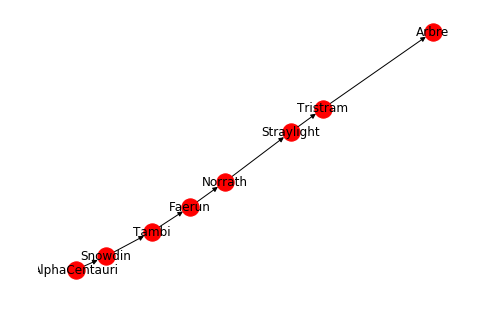

In [15]:
nx.draw(G, with_labels=True)